# 사전 준비

## 구글 드라이브 마운트

1) 왼쪽의 네 개 아이콘 중, 맨 아래 아이콘 클릭해,

2) Google Drive 아이콘 클릭하여, Google Drive를 마운트합니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
base_gdrive_path = 'drive/MyDrive/lecture_220718'

# base_gdrive_path = os.path.join('drive', 'MyDrive', 'lecture_220718')

In [ ]:
from pathlib import Path
import os

result_path = os.path.join(base_gdrive_path, "results")
Path(result_path).mkdir(parents=True, exist_ok=True)

# Imports

In [ ]:
# TensorFlow 및 tf.keras
import tensorflow as tf
from tensorflow import keras

# 도움 라이브러리
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.8.2


# CIFAR 100

## 데이터 다운 및 분석

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar100.load_data()

169017344/169001437 [==============================] - 10s 0us/step


In [ ]:
print("트레이닝 이미지 shape: {}, dtype: {}".format(train_images.shape, train_images.dtype))
print("트레이닝 라벨 shape: {}, dtype: {}".format(train_labels.shape, train_labels.dtype))

트레이닝 이미지 shape: (50000, 32, 32, 3), dtype: uint8
트레이닝 라벨 shape: (50000, 1), dtype: int64


In [ ]:
# 각 숫자의 개수
from collections import Counter
Counter(list(map(lambda el: el[0], train_labels)))

Counter({0: 500,
         1: 500,
         2: 500,
         3: 500,
         4: 500,
         5: 500,
         6: 500,
         7: 500,
         8: 500,
         9: 500,
         10: 500,
         11: 500,
         12: 500,
         13: 500,
         14: 500,
         15: 500,
         16: 500,
         17: 500,
         18: 500,
         19: 500,
         20: 500,
         21: 500,
         22: 500,
         23: 500,
         24: 500,
         25: 500,
         26: 500,
         27: 500,
         28: 500,
         29: 500,
         30: 500,
         31: 500,
         32: 500,
         33: 500,
         34: 500,
         35: 500,
         36: 500,
         37: 500,
         38: 500,
         39: 500,
         40: 500,
         41: 500,
         42: 500,
         43: 500,
         44: 500,
         45: 500,
         46: 500,
         47: 500,
         48: 500,
         49: 500,
         50: 500,
         51: 500,
         52: 500,
         53: 500,
         54: 500,
         55: 500,
  

In [ ]:
print("테스트 이미지 shape: {}, dtype: {}".format(test_images.shape, test_images.dtype))
print("테스트 라벨 shape: {}, dtype: {}".format(test_labels.shape, test_labels.dtype))

테스트 이미지 shape: (10000, 32, 32, 3), dtype: uint8
테스트 라벨 shape: (10000, 1), dtype: int64


## 데이터 전처리

샘플 데이터 하나 살펴보기

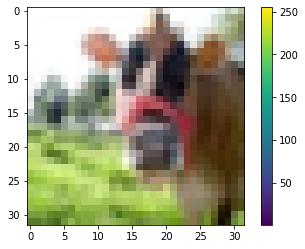

In [ ]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

데이터를 비율로 변경. 트레이닝을 더 잘 시키기 위함

In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0

binary cmap으로 트레이닝 이미지 여러 개 살펴보기

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


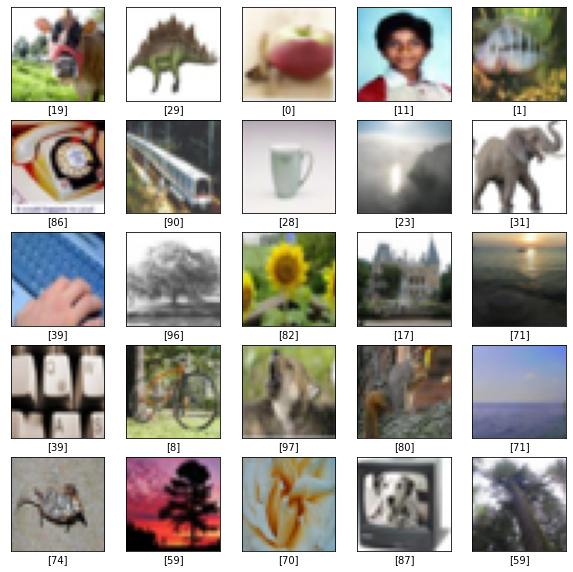

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(train_labels[i])
plt.show()

# ResNet

## 모델 (34-layer-residual)

In [ ]:
def resnet_34(input_shape = (224, 224, 3), class_num = 1000):
    base_channel_num = 32  # 64

    input = keras.layers.Input(input_shape)
    conv_1 = keras.layers.Conv2D(base_channel_num, 7, 2, padding="same", activation="relu")(input)
    pool_1 = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(conv_1)

    conv_2_residual = pool_1
    conv_2 = keras.layers.Conv2D(base_channel_num, 3, padding="same", activation="relu")(pool_1)
    conv_2 = keras.layers.Conv2D(base_channel_num, 3, padding="same", activation="relu")(conv_2)
    conv_2 = keras.layers.Add()([conv_2, conv_2_residual])  # 1
    for i in range(2):
        conv_2_residual = conv_2
        conv_2 = keras.layers.Conv2D(base_channel_num, 3, padding="same", activation="relu")(conv_2)
        conv_2 = keras.layers.Conv2D(base_channel_num, 3, padding="same", activation="relu")(conv_2)
        conv_2 = keras.layers.Add()([conv_2, conv_2_residual])  # 2
    
    conv_3_residual = conv_2
    conv_3_residual = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(conv_3_residual)
    conv_3_residual = keras.layers.Conv2D(base_channel_num*2, 1, padding="same", activation="relu")(conv_3_residual)
    conv_3 = keras.layers.Conv2D(base_channel_num*2, 3, strides=2, padding="same", activation="relu")(conv_2)
    conv_3 = keras.layers.Conv2D(base_channel_num*2, 3, padding="same", activation="relu")(conv_3)
    conv_3 = keras.layers.Add()([conv_3, conv_3_residual])  # 1
    for i in range(3):
        conv_3_residual = conv_3
        conv_3 = keras.layers.Conv2D(base_channel_num*2, 3, padding="same", activation="relu")(conv_3)
        conv_3 = keras.layers.Conv2D(base_channel_num*2, 3, padding="same", activation="relu")(conv_3)
        conv_3 = keras.layers.Add()([conv_3, conv_3_residual])  # 2-4

    conv_4_residual = conv_3
    conv_4_residual = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(conv_4_residual)
    conv_4_residual = keras.layers.Conv2D(base_channel_num*4, 1, activation="relu")(conv_4_residual)
    conv_4 = keras.layers.Conv2D(base_channel_num*4, 3, strides=2, padding="same", activation="relu")(conv_3)
    conv_4 = keras.layers.Conv2D(base_channel_num*4, 3, padding="same", activation="relu")(conv_4)
    conv_4 = keras.layers.Add()([conv_4, conv_4_residual])  # 1
    for i in range(5):
        conv_4_residual = conv_4
        conv_4 = keras.layers.Conv2D(base_channel_num*4, 3, padding="same", activation="relu")(conv_4)
        conv_4 = keras.layers.Conv2D(base_channel_num*4, 3, padding="same", activation="relu")(conv_4)
        conv_4 = keras.layers.Add()([conv_4, conv_4_residual])  # 2-6

    conv_5_residual = conv_4
    conv_5_residual = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(conv_5_residual)
    conv_5_residual = keras.layers.Conv2D(base_channel_num*8, 1, activation="relu")(conv_5_residual)
    conv_5 = keras.layers.Conv2D(base_channel_num*8, 3, strides=2, padding="same", activation="relu")(conv_4)
    conv_5 = keras.layers.Conv2D(base_channel_num*8, 3, padding="same", activation="relu")(conv_5)
    conv_5 = keras.layers.Add()([conv_5, conv_5_residual])  # 1
    for i in range(2):
        conv_5_residual = conv_5
        conv_5 = keras.layers.Conv2D(base_channel_num*8, 3, padding="same", activation="relu")(conv_5)
        conv_5 = keras.layers.Conv2D(base_channel_num*8, 3, padding="same", activation="relu")(conv_5)
        conv_5 = keras.layers.Add()([conv_5, conv_5_residual])  # 2-3

    ap = keras.layers.GlobalAveragePooling2D()(conv_5)
    dense_1 = keras.layers.Dense(units=class_num, activation="softmax")(ap)

    return keras.models.Model(inputs=[input], outputs=[dense_1])


In [ ]:
model = resnet_34()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_116 (Conv2D)            (None, 112, 112, 32  4736        ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_20 (MaxPooling2D  (None, 56, 56, 32)  0           ['conv2d_116[0][0]']             
 )                                                                                            

In [ ]:
model = resnet_34(input_shape=(32, 32, 3), class_num=100)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_36 (Conv2D)             (None, 16, 16, 32)   4736        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 8, 8, 32)    0           ['conv2d_36[0][0]']              
                                                                                                  
 conv2d_37 (Conv2D)             (None, 8, 8, 32)     9248        ['max_pooling2d_4[0][0]']        
                                                                                            

## 트레이닝

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
history = model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 32s 13ms/step - loss: 4.3675 - sparse_categorical_accuracy: 0.0286
Epoch 2/10
1563/1563 [==============================] - 20s 13ms/step - loss: 3.8771 - sparse_categorical_accuracy: 0.0927
Epoch 3/10
1563/1563 [==============================] - 20s 13ms/step - loss: 3.5064 - sparse_categorical_accuracy: 0.1551
Epoch 4/10
1563/1563 [==============================] - 21s 14ms/step - loss: 3.2664 - sparse_categorical_accuracy: 0.2001
Epoch 5/10
1563/1563 [==============================] - 20s 13ms/step - loss: 3.0937 - sparse_categorical_accuracy: 0.2341
Epoch 6/10
1563/1563 [==============================] - 21s 13ms/step - loss: 2.9564 - sparse_categorical_accuracy: 0.2590
Epoch 7/10
1563/1563 [==============================] - 20s 13ms/step - loss: 2.8447 - sparse_categorical_accuracy: 0.2813
Epoch 8/10
1563/1563 [==============================] - 20s 13ms/step - loss: 2.7488 - sparse_categorical_accuracy: 0.3007
Epoch 9/10
1563/

## 테스트 및 예측

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('테스트 정확도:', test_acc)

313/313 - 2s - loss: 2.9536 - sparse_categorical_accuracy: 0.2803 - 2s/epoch - 6ms/step
테스트 정확도: 0.28029999136924744


### 예측 보기

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)
  
def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(100))
  plt.yticks([])
  thisplot = plt.bar(range(100), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [ ]:
predictions = model.predict(test_images)

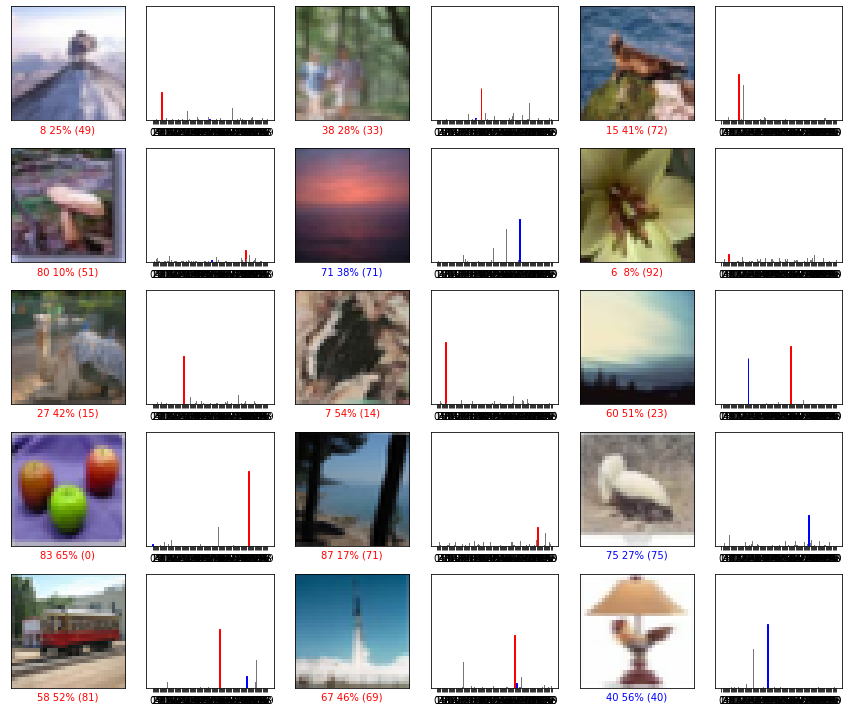

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
test_labels_2 = list(map(lambda el: el[0], test_labels))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels_2, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels_2)
plt.tight_layout()
plt.show()

## 함수로 축약한 모델

In [ ]:
# def resnet_34_function_model(input_shape = (224, 224, 3), class_num = 1000):
#     base_channel_num = 32  # 64

#     input = keras.layers.Input(input_shape)
#     conv_1 = keras.layers.Conv2D(base_channel_num, 7, 2, padding="same", activation="relu")(input)
#     pool_1 = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(conv_1)

#     conv_2_residual = pool_1
#     conv_2 = keras.layers.Conv2D(base_channel_num, 3, padding="same", activation="relu")(pool_1)
#     conv_2 = keras.layers.Conv2D(base_channel_num, 3, padding="same", activation="relu")(conv_2)
#     conv_2 = keras.layers.Add()([conv_2, conv_2_residual])  # 1
#     for i in range(2):
#         conv_2_residual = conv_2
#         conv_2 = keras.layers.Conv2D(base_channel_num, 3, padding="same", activation="relu")(conv_2)
#         conv_2 = keras.layers.Conv2D(base_channel_num, 3, padding="same", activation="relu")(conv_2)
#         conv_2 = keras.layers.Add()([conv_2, conv_2_residual])  # 2
    
#     conv_3_residual = conv_2
#     conv_3_residual = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(conv_3_residual)
#     conv_3_residual = keras.layers.Conv2D(base_channel_num*2, 1, padding="same", activation="relu")(conv_3_residual)
#     conv_3 = keras.layers.Conv2D(base_channel_num*2, 3, strides=2, padding="same", activation="relu")(conv_2)
#     conv_3 = keras.layers.Conv2D(base_channel_num*2, 3, padding="same", activation="relu")(conv_3)
#     conv_3 = keras.layers.Add()([conv_3, conv_3_residual])  # 1
#     for i in range(3):
#         conv_3_residual = conv_3
#         conv_3 = keras.layers.Conv2D(base_channel_num*2, 3, padding="same", activation="relu")(conv_3)
#         conv_3 = keras.layers.Conv2D(base_channel_num*2, 3, padding="same", activation="relu")(conv_3)
#         conv_3 = keras.layers.Add()([conv_3, conv_3_residual])  # 2-4

#     conv_4_residual = conv_3
#     conv_4_residual = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(conv_4_residual)
#     conv_4_residual = keras.layers.Conv2D(base_channel_num*4, 1, activation="relu")(conv_4_residual)
#     conv_4 = keras.layers.Conv2D(base_channel_num*4, 3, strides=2, padding="same", activation="relu")(conv_3)
#     conv_4 = keras.layers.Conv2D(base_channel_num*4, 3, padding="same", activation="relu")(conv_4)
#     conv_4 = keras.layers.Add()([conv_4, conv_4_residual])  # 1
#     for i in range(5):
#         conv_4_residual = conv_4
#         conv_4 = keras.layers.Conv2D(base_channel_num*4, 3, padding="same", activation="relu")(conv_4)
#         conv_4 = keras.layers.Conv2D(base_channel_num*4, 3, padding="same", activation="relu")(conv_4)
#         conv_4 = keras.layers.Add()([conv_4, conv_4_residual])  # 2-6

#     conv_5_residual = conv_4
#     conv_5_residual = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(conv_5_residual)
#     conv_5_residual = keras.layers.Conv2D(base_channel_num*8, 1, activation="relu")(conv_5_residual)
#     conv_5 = keras.layers.Conv2D(base_channel_num*8, 3, strides=2, padding="same", activation="relu")(conv_4)
#     conv_5 = keras.layers.Conv2D(base_channel_num*8, 3, padding="same", activation="relu")(conv_5)
#     conv_5 = keras.layers.Add()([conv_5, conv_5_residual])  # 1
#     for i in range(2):
#         conv_5_residual = conv_5
#         conv_5 = keras.layers.Conv2D(base_channel_num*8, 3, padding="same", activation="relu")(conv_5)
#         conv_5 = keras.layers.Conv2D(base_channel_num*8, 3, padding="same", activation="relu")(conv_5)
#         conv_5 = keras.layers.Add()([conv_5, conv_5_residual])  # 2-3

#     ap = keras.layers.GlobalAveragePooling2D()(conv_5)
#     dense_1 = keras.layers.Dense(units=class_num, activation="softmax")(ap)

#     return keras.models.Model(inputs=[input], outputs=[dense_1])

In [ ]:
def resnet_34_function_model(input_shape = (224, 224, 3), class_num = 1000):


def resnet_34_1(input: tf.Tensor, base_channel_num = 64):

def resnet_34_2(input: tf.Tensor, base_channel_num = 64):

def resnet_34_3(input: tf.Tensor, base_channel_num = 64):


def resnet_34_4(input: tf.Tensor, base_channel_num = 64):


def resnet_34_5(input: tf.Tensor, base_channel_num = 64):


In [ ]:
model_2 = resnet_34_function_model()
model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_72 (Conv2D)             (None, 112, 112, 32  4736        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 56, 56, 32)  0           ['conv2d_72[0][0]']              
                                                                                            

## 커스텀 레이어 사용한 모델

In [ ]:
# def resnet_34_1(input: tf.Tensor, base_channel_num = 64):
#     conv_1 = keras.layers.Conv2D(filters=base_channel_num, kernel_size=7, strides=2, padding='same', activation='relu')(input)
#     conv_2 = keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(conv_1)
#     return conv_2 

class ResNetFirstLayer(tf.keras.layers.Layer):


In [ ]:
# def resnet_34_2(input: tf.Tensor, base_channel_num = 64):
#     result = input
#     for i in range(3):
#         layer_input_skip = result
#         conv_2 = keras.layers.Conv2D(filters=base_channel_num, kernel_size=3, padding='same', activation='relu')(result)
#         conv_2 = keras.layers.Conv2D(filters=base_channel_num, kernel_size=3, padding='same', activation='relu')(conv_2)
#         conv_2 = keras.layers.Add()([conv_2, layer_input_skip])
#         result = conv_2
#     return result
    
class ResNetSecondLayer(tf.keras.layers.Layer):


In [ ]:
# def resnet_34_3(input: tf.Tensor, base_channel_num = 64):
#     input_residual = input
#     input_residual = keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(input_residual)
#     input_residual = keras.layers.Conv2D(filters=base_channel_num, kernel_size=1, padding="same", activation='relu')(input_residual)
#     input = keras.layers.Conv2D(filters=base_channel_num, kernel_size=3, strides=2, padding="same", activation='relu')(input)
#     input = keras.layers.Conv2D(filters=base_channel_num, kernel_size=3, padding="same", activation='relu')(input)
#     input = keras.layers.Add()([input, input_residual])

#     result = input
#     for i in range(3):
#         layer_input_skip = result
#         conv_2 = keras.layers.Conv2D(filters=base_channel_num, kernel_size=3, padding='same', activation='relu')(result)
#         conv_2 = keras.layers.Conv2D(filters=base_channel_num, kernel_size=3, padding='same', activation='relu')(conv_2)
#         conv_2 = keras.layers.Add()([conv_2, layer_input_skip])
#         result = conv_2
#     return result
    
class ResNetThirdLayer(tf.keras.layers.Layer):
    def __init__(self, channel_num):
        super().__init__()
        self.channel_num = channel_num


    def call(self, inputs):


In [ ]:
# def resnet_34_4(input: tf.Tensor, base_channel_num = 64):
#     input_residual = input
#     input_residual = keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(input_residual)
#     input_residual = keras.layers.Conv2D(filters=base_channel_num, kernel_size=1, padding="same", activation='relu')(input_residual)
#     input = keras.layers.Conv2D(filters=base_channel_num, kernel_size=3, strides=2, padding="same", activation='relu')(input)
#     input = keras.layers.Conv2D(filters=base_channel_num, kernel_size=3, padding="same", activation='relu')(input)
#     input = keras.layers.Add()([input, input_residual])

#     result = input
#     for i in range(5):
#         layer_input_skip = result
#         conv_2 = keras.layers.Conv2D(filters=base_channel_num, kernel_size=3, padding='same', activation='relu')(result)
#         conv_2 = keras.layers.Conv2D(filters=base_channel_num, kernel_size=3, padding='same', activation='relu')(conv_2)
#         conv_2 = keras.layers.Add()([conv_2, layer_input_skip])
#         result = conv_2
#     return result

class ResNetFourthLayer(tf.keras.layers.Layer):
    def __init__(self, channel_num):
        super().__init__()
        self.channel_num = channel_num

        self.residual_conv = keras.layers.Conv2D(filters=channel_num, kernel_size=1, padding="same", activation='relu')

        self.conv_1a = keras.layers.Conv2D(filters=channel_num, kernel_size=3, strides=2, padding="same", activation='relu')
        self.conv_1b = keras.layers.Conv2D(filters=channel_num, kernel_size=3, padding="same", activation='relu')

        self.conv_list = [keras.layers.Conv2D(filters=channel_num, kernel_size=3, padding='same', activation='relu') for i in range(2*5)]

    def call(self, inputs):
        x_residual = inputs
        x_residual = keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(x_residual)
        x_residual = self.residual_conv(x_residual)
        x = self.conv_1a(inputs)
        x = self.conv_1b(x)
        x = keras.layers.Add()([x, x_residual])

        for i in range(5):
            x_residual = x
            x = self.conv_list[2*i](x)
            x = self.conv_list[2*i+1](x)
            x = keras.layers.Add()([x, x_residual])
        return x

In [ ]:
# def resnet_34_5(input: tf.Tensor, base_channel_num = 64):
#     input_residual = input
#     input_residual = keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(input_residual)
#     input_residual = keras.layers.Conv2D(filters=base_channel_num, kernel_size=1, padding="same", activation='relu')(input_residual)
#     input = keras.layers.Conv2D(filters=base_channel_num, kernel_size=3, strides=2, padding="same", activation='relu')(input)
#     input = keras.layers.Conv2D(filters=base_channel_num, kernel_size=3, padding="same", activation='relu')(input)
#     input = keras.layers.Add()([input, input_residual])

#     result = input
#     for i in range(2):
#         layer_input_skip = result
#         conv_2 = keras.layers.Conv2D(filters=base_channel_num, kernel_size=3, padding='same', activation='relu')(result)
#         conv_2 = keras.layers.Conv2D(filters=base_channel_num, kernel_size=3, padding='same', activation='relu')(conv_2)
#         conv_2 = keras.layers.Add()([conv_2, layer_input_skip])
#         result = conv_2
#     return result

class ResNetFifthLayer(tf.keras.layers.Layer):
    def __init__(self, channel_num, repeat_num=2):
        super().__init__()
        self.channel_num = channel_num
        self.repeat_num = repeat_num

        self.residual_conv = keras.layers.Conv2D(filters=channel_num, kernel_size=1, padding="same", activation='relu')

        self.conv_1a = keras.layers.Conv2D(filters=channel_num, kernel_size=3, strides=2, padding="same", activation='relu')
        self.conv_1b = keras.layers.Conv2D(filters=channel_num, kernel_size=3, padding="same", activation='relu')



    def call(self, inputs):
        

In [ ]:
def resnet_34_custom_layer_model(input_shape = (224, 224, 3), class_num = 1000):
    base_channel_num = 32  # 64 in paper
    input = keras.layers.Input(input_shape)

    first = ResNetFirstLayer(channel_num=base_channel_num)(input)
    second = ResNetSecondLayer(channel_num=base_channel_num)(first)
    third = ResNetThirdLayer(channel_num=base_channel_num*2)(second)
    fourth = ResNetFourthLayer(channel_num=base_channel_num*4)(third)
    fifth = ResNetFifthLayer(channel_num=base_channel_num*8)(fourth)
    
    ap = keras.layers.GlobalAveragePooling2D()(fifth)
    dense_1 = keras.layers.Dense(units=class_num, activation="softmax")(ap)
    
    return keras.models.Model(inputs=[input], outputs=[dense_1])

In [ ]:
model_3 = resnet_34_custom_layer_model()
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 res_net_first_layer (ResNet  (None, 56, 56, 32)       4736      
 FirstLayer)                                                     
                                                                 
 res_net_second_layer (ResNe  (None, 56, 56, 32)       55488     
 tSecondLayer)                                                   
                                                                 
 res_net_third_layer (ResNet  (None, 28, 28, 64)       279104    
 ThirdLayer)                                                     
                                                                 
 res_net_fourth_layer (ResNe  (None, 14, 14, 128)      1705600   
 tFourthLayer)                                             

In [ ]:
def resnet_34_custom_layer_model_2(input_shape = (224, 224, 3), class_num = 1000):
    base_channel_num = 32  # 64 in paper
    input = keras.layers.Input(input_shape)

    first = ResNetFirstLayer(channel_num=base_channel_num)(input)
    second = ResNetSecondLayer(channel_num=base_channel_num)(first)
    third = ResNetFifthLayer(channel_num=base_channel_num*2, repeat_num=3)(second)
    fourth = ResNetFifthLayer(channel_num=base_channel_num*4, repeat_num=5)(third)
    fifth = ResNetFifthLayer(channel_num=base_channel_num*8, repeat_num=2)(fourth)
    
    ap = keras.layers.GlobalAveragePooling2D()(fifth)
    dense_1 = keras.layers.Dense(units=class_num, activation="softmax")(ap)
    
    return keras.models.Model(inputs=[input], outputs=[dense_1])

In [ ]:
model_4 = resnet_34_custom_layer_model_2()
model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 res_net_first_layer_1 (ResN  (None, 56, 56, 32)       4736      
 etFirstLayer)                                                   
                                                                 
 res_net_second_layer_1 (Res  (None, 56, 56, 32)       55488     
 NetSecondLayer)                                                 
                                                                 
 res_net_fifth_layer_1 (ResN  (None, 28, 28, 64)       279104    
 etFifthLayer)                                                   
                                                                 
 res_net_fifth_layer_2 (ResN  (None, 14, 14, 128)      1705600   
 etFifthLayer)                                             